## Fitting the LightGBM on the train sataset and stesting the result

In [1]:
!pip install lightgbm

In [18]:
# Load the necessary libraries and packages 
import pandas as pd 
import numpy as np 
import lightgbm as lgb 
from sklearn.metrics import r2_score, roc_auc_score, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold # for cv in a regression model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from collections import defaultdict

In [3]:
# Load training data
X_train = pd.read_csv("../data/X_train_wodum.csv")
y_train = pd.read_csv("../data/y_train_wodum.csv")

# Ensure y_train is a 1D array (it's necessary for LightGBM)
y_train = y_train.squeeze()

# Check the first few rows
print(X_train.shape, y_train.shape)
X_train.head()


(74943, 11) (74943,)


,airline,std_day,sta_day,std_month,sta_month,std_time_dec,iso_country_dep,type_dep,iso_country_arr,type_arr,is_same_country
0,TU,Sunday,Sunday,February,February,11.4,BE,large_airport,TN,large_airport,False
1,TU,Friday,Friday,May,May,18.2,FR,medium_airport,TN,medium_airport,False
2,TU,Saturday,Saturday,June,June,13.8,FR,large_airport,TN,large_airport,False
3,TU,Saturday,Saturday,January,January,9.3,DE,large_airport,TN,medium_airport,False
4,TU,Wednesday,Wednesday,August,August,10.0,SI,large_airport,TN,medium_airport,False


In [4]:
y_train.describe()

count    74943.000000
mean         2.657061
std          1.861390
min          0.000000
25%          0.000000
50%          2.995732
75%          3.931826
max          8.146709
Name: target, dtype: float64

In [11]:
# Enconding 

# Copy the original dataset to avoid modifying it directly
X_train_encoded = X_train.copy()

# Identify categorical features (object types)
categorical_features = X_train_encoded.select_dtypes(include=['object']).columns.tolist()

# Encode categorical variables using Label Encoding
label_encoders = {}  # Store encoders for potential future use (like test data)
for col in categorical_features:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col])  # Encode column
    label_encoders[col] = le  # Save encoder for later

# Convert boolean feature to integer (0/1)
X_train_encoded['is_same_country'] = X_train_encoded['is_same_country'].astype(int)

# Confirm encoding
print(f"Categorical Features Encoded: {categorical_features}")
print(X_train_encoded.head())  # Display the transformed dataset


Categorical Features Encoded: ['airline', 'std_day', 'sta_day', 'std_month', 'sta_month', 'iso_country_dep', 'type_dep', 'iso_country_arr', 'type_arr']
   airline  std_day  sta_day  std_month  sta_month  std_time_dec   
0       10        3        3          3          3          11.4  \
1       10        0        0          8          8          18.2   
2       10        2        2          6          6          13.8   
3       10        2        2          4          4           9.3   
4       10        6        6          1          1          10.0   

   iso_country_dep  type_dep  iso_country_arr  type_arr  is_same_country  
0                2         0               46         0                0  
1               16         1               46         1                0  
2               16         0               46         0                0  
3               10         0               46         1                0  
4               44         0               46         1         

In [13]:
# CV and LightGMB 


# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# LightGBM parameters
params = {
    'objective': 'regression',  # Task type: regression
    'metric': 'mae',  # Optimization metric: Mean Absolute Error
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Trees
    'learning_rate': 0.05,  # Step size for updating predictions
    'num_leaves': 31,  # Maximum tree leaves for base learners
    'max_depth': -1  # No limit on tree depth
}

mae_scores = []  # Store MAE scores for each fold
mse_scores = []  # Store MSE scores for each fold

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_encoded, y_train)):

    # Split training and validation data
    X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Convert data into LightGBM dataset format
    train_data = lgb.Dataset(X_tr, label=y_tr)
    valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Train LightGBM model with early stopping
    model = lgb.train(
        params,  # LightGBM hyperparameters
        train_data,  # Training dataset
        num_boost_round=100,  # Maximum boosting rounds
        valid_sets=[valid_data],  # Validation dataset
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)]  # Stop if no improvement for 10 rounds
    )

    # Make predictions on the validation set
    y_pred = model.predict(X_val)

    # Compute MAE (lower is better)
    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)
    
    # Compute MSE
    mse = mean_squared_error(y_val, y_pred)
    mse_scores.append(mse)

    print(f"Fold {fold+1} MAE: {mae:.4f}")  # Print MAE for the fold
    print(f"Fold {fold+1} MSE: {mse:.4f}")

# Compute and display the average MAE across all folds
print(f"\n Average MAE from Cross-Validation: {np.mean(mae_scores):.4f}")
# Compute and display the average MSE across all folds
avg_mse = np.mean(mse_scores)
print(f"\n Average MSE from Cross-Validation: {avg_mse:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 59954, number of used features: 11
[LightGBM] [Info] Start training from score 2.656133
Training until validation scores don't improve for 10 rounds
[10]	valid_0's l1: 1.45958
[20]	valid_0's l1: 1.41819
[30]	valid_0's l1: 1.3926
[40]	valid_0's l1: 1.37536
[50]	valid_0's l1: 1.36388
[60]	valid_0's l1: 1.35554
[70]	valid_0's l1: 1.34832
[80]	valid_0's l1: 1.34318
[90]	valid_0's l1: 1.33917
[100]	valid_0's l1: 1.33586
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 1.33586
Fold 1 MAE: 1.3359
Fold 1 MSE: 2.7541
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001931 seconds.
You can set `force_row_wise=true` to remove th

# Observations from the Output

1. **Validation Scores Across Folds**

* The MAE values for each fold are close to each other, meaning the model has stable performance across different validation splits.

2. **Early Stopping Was Not Triggered**

* LightGBM was set to stop training early if validation MAE did not improve for 10 rounds (`lgb.early_stopping(10)`). However, in all folds, validation MAE kept improving until round 100.
* This suggests:
    * More boosting rounds might be beneficial.
    * The model is not overfitting too quickly.

In [14]:
# Load testing data
X_test = pd.read_csv("../data/X_test_wodum.csv")
y_test = pd.read_csv("../data/y_test_wodum.csv")

# Ensure y_train is a 1D array (it's necessary for LightGBM)
y_test = y_test.squeeze()

# Check the first few rows
print(X_test.shape, y_test.shape)
X_test.head()

(18736, 11) (18736,)


,airline,std_day,sta_day,std_month,sta_month,std_time_dec,iso_country_dep,type_dep,iso_country_arr,type_arr,is_same_country
0,TU,Wednesday,Wednesday,August,August,9.3,TN,large_airport,FR,large_airport,False
1,TU,Tuesday,Tuesday,August,August,13.3,TN,large_airport,FR,large_airport,False
2,TU,Saturday,Saturday,June,June,6.0,FR,large_airport,TN,large_airport,False
3,TU,Tuesday,Tuesday,January,January,10.5,MA,large_airport,TN,large_airport,False
4,TU,Tuesday,Tuesday,February,February,8.2,TN,large_airport,DZ,large_airport,False


In [16]:
# Enconding the test 

# Copy the original dataset to avoid modifying it directly
X_test_encoded = X_test.copy()

# Identify categorical features (object types)
categorical_features = X_test_encoded.select_dtypes(include=['object']).columns.tolist()

# Encode categorical variables using Label Encoding
label_encoders = {}  # Store encoders for potential future use (like test data)
for col in categorical_features:
    le = LabelEncoder()
    X_test_encoded[col] = le.fit_transform(X_test_encoded[col])  # Encode column
    label_encoders[col] = le  # Save encoder for later

# Convert boolean feature to integer (0/1)
X_test_encoded['is_same_country'] = X_test_encoded['is_same_country'].astype(int)

# Confirm encoding
print(f"Categorical Features Encoded: {categorical_features}")
print(X_test_encoded.head())  # Display the transformed dataset

Categorical Features Encoded: ['airline', 'std_day', 'sta_day', 'std_month', 'sta_month', 'iso_country_dep', 'type_dep', 'iso_country_arr', 'type_arr']
   airline  std_day  sta_day  std_month  sta_month  std_time_dec   
0       10        6        6          1          1           9.3  \
1       10        5        5          1          1          13.3   
2       10        2        2          6          6           6.0   
3       10        5        5          4          4          10.5   
4       10        5        5          3          3           8.2   

   iso_country_dep  type_dep  iso_country_arr  type_arr  is_same_country  
0               43         0               13         0                0  
1               43         0               13         0                0  
2               16         0               36         0                0  
3               26         0               36         0                0  
4               43         0               10         0         

In [17]:
# Make predictions on the test set
y_test_pred = model.predict(X_test_encoded)

# Compute Mean Absolute Error (MAE)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Compute Mean Squared Error (MSE)
mse_test = mean_squared_error(y_test, y_test_pred)

# Print results
print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")

Test MAE: 1.3800
Test MSE: 2.8905


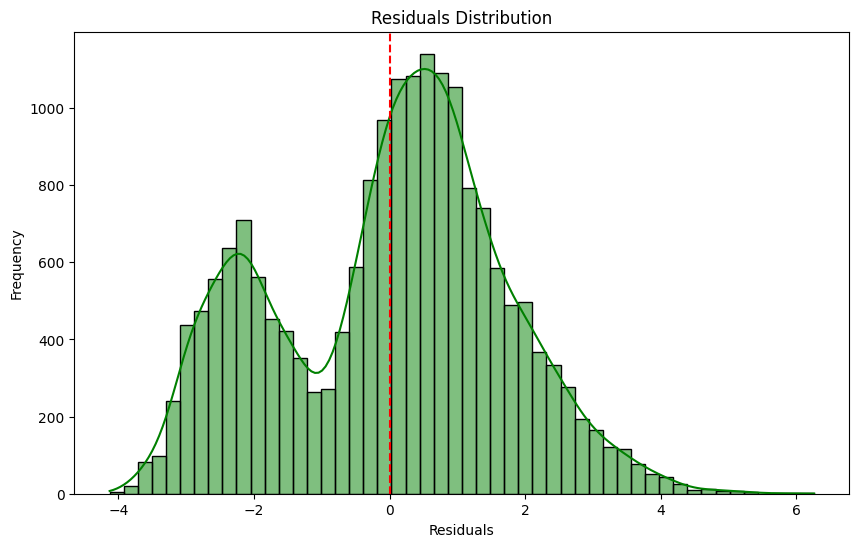

In [21]:
# Compute residuals
residuals = y_test - y_test_pred

# Plot the residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True, color='green')
plt.axvline(0, color='red', linestyle='dashed')  # Zero error line
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()
